In [1]:
# Enable outputting results interactively. 
# All the results from code in a given cell will be displayed instead of only the last one.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [46]:
import pandas as pd
import json
import pickle
import numpy as np
import scipy.stats as stats
import sqlite3
import math
import datetime
import matplotlib.dates as mdates

from re import sub
from decimal import Decimal

import re

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()



#### Construct time series of supplies

In [49]:
def supply_func(city):
    
    listings_0 =  pickle.load( open( f"../data/all_{city}_listings.p", "rb" ) )

    # Flag listings of which the min. nights is less than 30 days. Rentals of 30 days and above are not subject to the new regulations.

    # boolean values;

    listings_0['short_term'] = (listings_0['minimum_nights']<30) * 1 
    listings_0['long_term'] = (listings_0['minimum_nights']>=30) * 1

    listings_0['scraped_dt2'] = pd.to_datetime(listings_0['file_scraped_dt'])
    listings_0 = listings_0.drop('file_scraped_dt',axis = 1)
    listings_0.columns = ['file_scraped_dt' if x=='scraped_dt2' else x for x in listings_0.columns]

    listings_0['scraped_year'] = listings_0['file_scraped_dt'].dt.year 

    listings_t = listings_0.set_index(pd.DatetimeIndex(listings_0['file_scraped_dt']))

    listings_short = listings_t[listings_t['short_term'] == 1]

    m_ls = listings_short.resample('D').size().reset_index(name = f"{city}_counts") 

    listings_short_avail = listings_short[listings_short['availability_90'] > 0]
    
    pd.reset_option('mode.chained_assignment')
    with pd.option_context('mode.chained_assignment', None):
    
        listings_short_avail['price_float'] = listings_short_avail['price'].str.replace("\$|,", "").astype(float)

    m_ls_avail = listings_short_avail.resample('D').size().reset_index(name= f"{city}_counts") 

    return m_ls, m_ls_avail, listings_short_avail

In [50]:
monthly_supply_portland, monthly_supply_avail_portland, ls_short_avail_portland = supply_func("Portland")

In [51]:
monthly_supply_sf, monthly_supply_avail_sf, ls_short_avail_sf = supply_func("SF")

In [52]:
monthly_supply_portland.shape, monthly_supply_sf.shape

((1593, 2), (1527, 2))

In [144]:
def chart_supplies(df_port, df_sf, title):
    
    comp_supply = df_port.merge(df_sf, on = 'file_scraped_dt', how = 'outer')
    comp_supply = comp_supply.set_index(pd.DatetimeIndex(comp_supply['file_scraped_dt']))
    comp_supply = comp_supply['2015-05-01':]
    comp_supply = comp_supply[:'2019-06-30']


    xlinspace = pd.date_range('2015-05-01', periods= comp_supply.shape[0], freq='D')

    fig, ax = plt.subplots(1,figsize = (15,10))
    fig.autofmt_xdate()
    plt.scatter(xlinspace,comp_supply['SF_counts'], label = "San Francisco")
    plt.scatter(xlinspace,comp_supply['Portland_counts'], label = "Portland")


    # Deadline of compliance with regulation in SF

    plt.axvline(x= datetime.date(2018,1,16), color = 'red', linestyle='--')


    ax.set_ylim(0,10000)
    plt.xlabel("Date")
    plt.ylabel("Number of Bookings")
    plt.title(title, fontsize = 18)
    plt.legend()

    xfmt = mdates.DateFormatter('%m-%d-%y')


    plt.show();

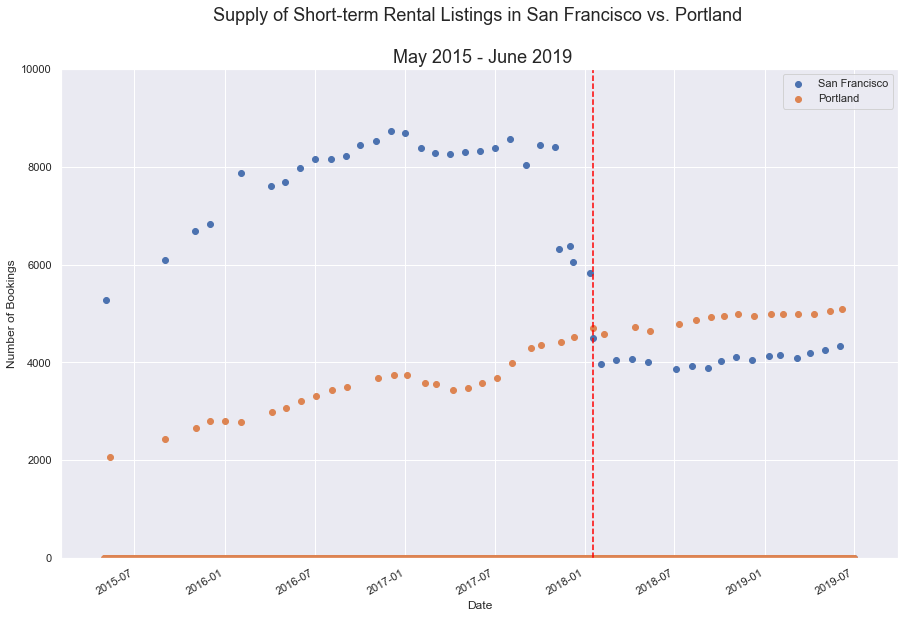

In [153]:
chart_supplies(monthly_supply_portland, monthly_supply_sf, 
               "Supply of Short-term Rental Listings in San Francisco vs. Portland \n \n May 2015 - June 2019")



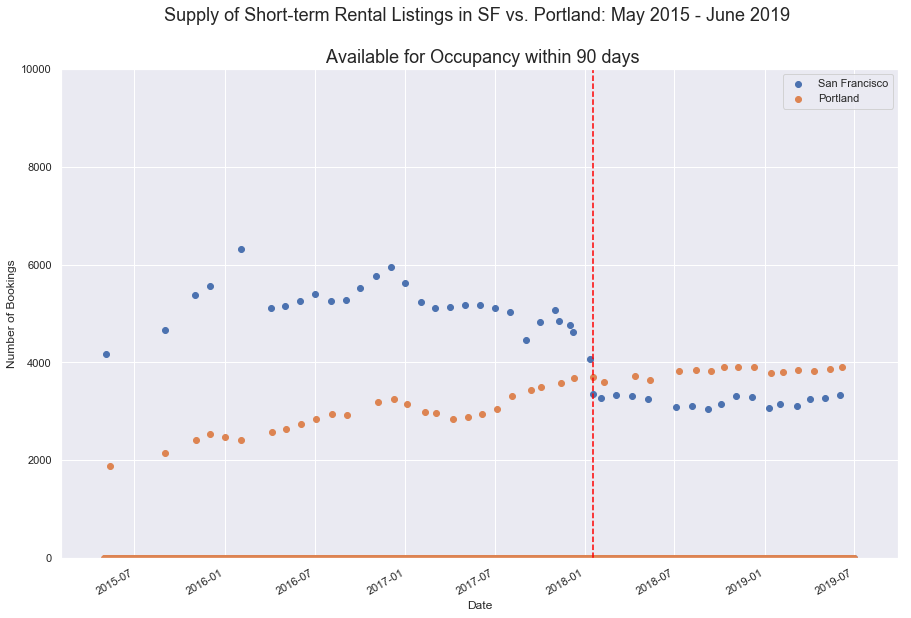

In [154]:
chart_supplies(monthly_supply_avail_portland, monthly_supply_avail_sf, 
               
    "Supply of Short-term Rental Listings in SF vs. Portland: May 2015 - June 2019 \n \n Available for Occupancy within 90 days")

#### Construct time series of demand

Use frequency of reviews as a proxy of demand.

Assumption: the ratio of occupany/reservation over number of reviews is constant in SF and Portland.


In [10]:
def weekly_demand(city):
    reviews =  pickle.load( open( f"../data/all_{city}_reviews.p", "rb" ) )
    reviews = reviews.set_index(pd.DatetimeIndex(reviews['date']))

    reviews_tab = reviews.resample('W').size().reset_index(name=f"{city}_counts") 
    reviews_tab = reviews_tab.set_index(pd.DatetimeIndex(reviews_tab['date']))

    reviews_tab_post2015 = reviews_tab['2015-05-01':]
    
    return reviews_tab_post2015

In [11]:
weekly_demand_sf = weekly_demand("SF")
weekly_demand_portland = weekly_demand('Portland')

In [12]:
weekly_demand_sf.shape, weekly_demand_portland.shape

((219, 2), (220, 2))

In [13]:
comp_weekly_demand = weekly_demand_portland.merge(weekly_demand_sf, on = 'date', how = 'outer')

In [14]:
comp_weekly_demand = comp_weekly_demand.iloc[:-2]

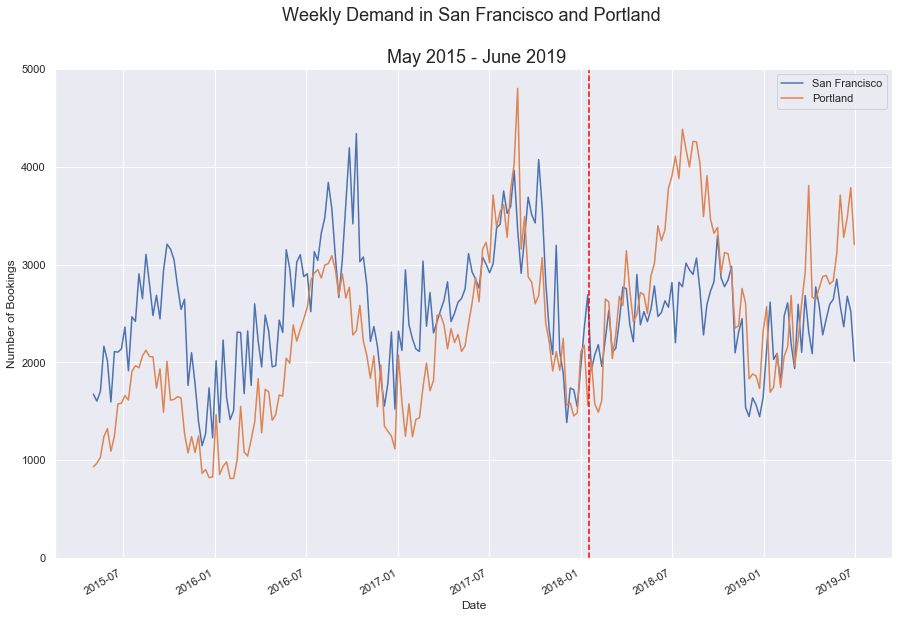

In [32]:
xlinspace = pd.date_range('2015-05-03', periods= comp_weekly_demand.shape[0], freq='W')

fig, ax = plt.subplots(1,figsize = (15,10))
fig.autofmt_xdate()
plt.plot(xlinspace,comp_weekly_demand['SF_counts'], label = "San Francisco")
plt.plot(xlinspace,comp_weekly_demand['Portland_counts'], label = "Portland")

# Deadline of compliance with regulation in SF

plt.axvline(x= datetime.date(2018,1,16), color = 'red', linestyle='--')


ax.set_ylim(0,5000)
plt.xlabel("Date")
plt.ylabel("Number of Bookings")
plt.title("Weekly Demand in San Francisco and Portland \n \n May 2015 - June 2019", fontsize = 18)
plt.legend()

xfmt = mdates.DateFormatter('%m-%d-%y')


plt.show();

#### Constructed time series of price

1. Limited to private rooms only

2. "Sticker price" in the Listings data

In [112]:
def price_series(city_df,city):

    private_room = city_df.loc[city_df['room_type'] == 'Private room']
    PR_p = np.asarray(private_room['price_float'])

    PR_1pct = np.percentile(PR_p, 1)
    PR_99pct = np.percentile(PR_p, 99)

    PR_1pct, PR_99pct

    # private_room = private_room[private_room['price_float'] <= PR_99pct ]
    # private_room_portland = private_room_portland[private_room_portland['price_float'] >= PR_1pct ]
    price_t = private_room.set_index(pd.DatetimeIndex(private_room['file_scraped_dt']))
    
#     avg_price = private_room.resample('D').size().reset_index(name= f"{city}_counts") 
    
    grouper = private_room.groupby(pd.Grouper(key='file_scraped_dt', freq='1D'))
    avg_price = grouper['price_float'].mean().reset_index(name = f"{city}_avg_price")
    
    return avg_price

In [113]:
avg_price_sf = price_series(ls_short_avail_sf, "SF")

In [116]:
avg_price_portland = price_series(ls_short_avail_portland, "Portland")

In [118]:
comp_price = avg_price_portland.merge(avg_price_sf, on = 'file_scraped_dt', how='outer')

In [120]:
comp_price = comp_price.set_index(pd.DatetimeIndex(comp_price['file_scraped_dt']))
comp_price = comp_price['2015-05-01':]
comp_price = comp_price[:'2019-06-30']

In [151]:
def chart_prices(df):
   

    xlinspace = pd.date_range('2015-05-01', periods= comp_price.shape[0], freq='D')

    fig, ax = plt.subplots(1,figsize = (15,10))
#     fig.autofmt_xdate()
#     plt.scatter(xlinspace,comp_price['SF_avg_price'], label = "San Francisco")
#     plt.scatter(xlinspace,comp_price['Portland_avg_price'], label = "Portland")



    sns.lineplot(x= 'file_scraped_dt', y='SF_avg_price', data = comp_price, label = "San Francisco")
    sns.lineplot(x= 'file_scraped_dt', y='Portland_avg_price', data = comp_price, label = "Portland")
    
    # Deadline of compliance with regulation in SF

    plt.axvline(x= datetime.date(2018,1,16), color = 'red', linestyle='--')


    ax.set_ylim(0,300)
    plt.xlabel("Date")
    plt.ylabel("Price $")
    plt.title("Average Price of Private Room Listings in SF vs Portland: \n \n May 2015 - June 2019", fontsize = 18)
    plt.legend()

    xfmt = mdates.DateFormatter('%m-%d-%y')


    plt.show();

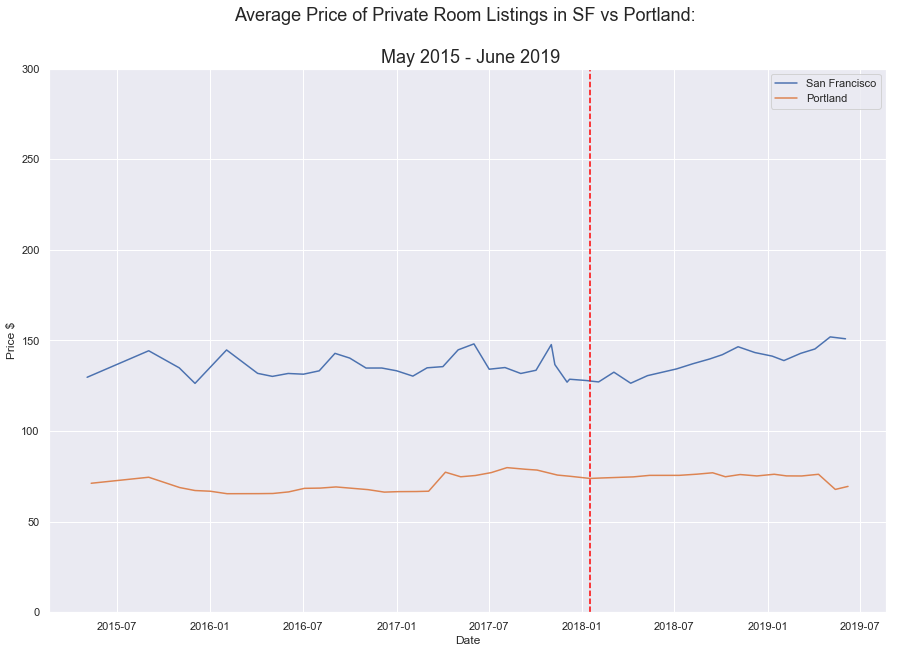

In [152]:
chart_prices(comp_price)